In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [170]:
import numpy as np
from scipy import stats, optimize
import pandas as pd

# Linear Discriminant Analysis

Predict groupings in continuous data.

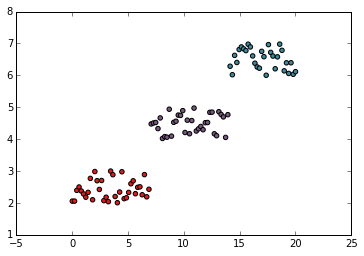

In [3]:
X = np.linspace(0, 20, 100)
def f(x):
    if x < 7:
        return 'a', 2. + np.random.random()
    elif x < 14:
        return 'b', 4 + np.random.random()
    else:
        return 'c', 6 + np.random.random()
K, Y = zip(*[f(x) for x in X])
colors = plt.get_cmap('Set1')
categories = ['a', 'b', 'c']
plt.scatter(X, Y, c=[colors(categories.index(k)*20) for k in K])
plt.show()

LDA is like inverted ANOVA: ANOVA looks for differences in a continuous response among categories, whereas LDA infers categories using a continuous predictor.

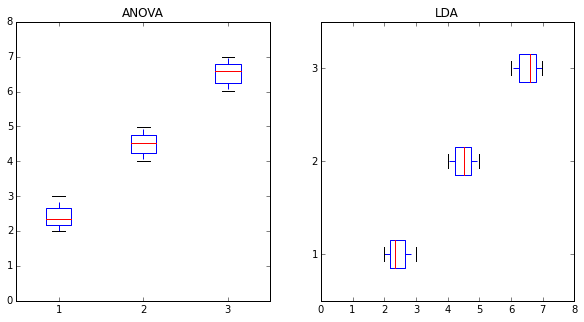

In [4]:
bycategory = [ [Y[i] for i in xrange(len(Y)) if K[i] == k] for k in categories ]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.boxplot(bycategory)
plt.ylim(0, 8)
plt.title('ANOVA')

plt.subplot(122)
plt.boxplot(bycategory, 0, 'rs', 0)
plt.title('LDA')
plt.xlim(0, 8)

plt.show()

LDA assumes that the variance in each group is the same, and that the predictor(s) are normally distributed for each group. In other words, different $\mu_k$, one shared $\sigma$.

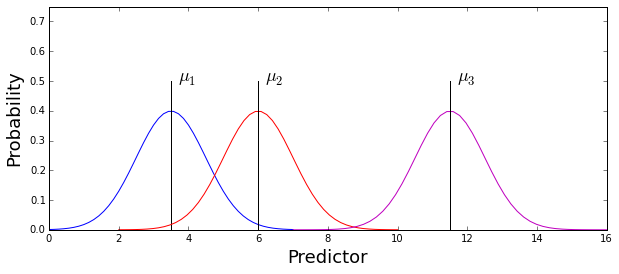

In [5]:
X = [np.linspace(0, 7, 50),
     np.linspace(2, 10, 50),
     np.linspace(7, 16, 50)]

plt.figure(figsize=(10, 4))
k = 1
for x in X:
    mu_k = x.mean()
    plt.plot(x, stats.norm.pdf(x, loc=mu_k))
    plt.plot([mu_k, mu_k], [0, 0.5], c='k')
    plt.text(mu_k + 0.2, 0.5, "$\mu_%i$" % k, size=18)
    k += 1
plt.ylim(0, 0.75)

plt.xlabel('Predictor', size=18)
plt.ylabel('Probability', size=18)
plt.show()

Recall Bayes Theorem: this allows us to "flip" the predictor and the response.

$P(A|B) = \frac{P(B|A)P(A)}{P(B|A) P(A) P(B|\bar{A}) P(\bar{A})}$

Therefore the probability of group $k$ given the continuous predictor B is:

$P(A_k|B) = \frac{P(B|A_k) P(A_k)}{\sum_{l=1}^k P(B|A_l) P(A_l)}$

The probability that a value $X=x$ came from group $Y=k$ is:

$P(Y=k|X=x) = \frac{f(x|Y=k)\pi(Y=k)}{\sum_{l=1}^k f(x|Y=l)\pi(Y=l)}$

Where $\pi(Y=k)$ is the probability of $Y=k$ regardless of $x$. This is just the relative representation of each group:

$\pi(Y=k) = \frac{n_k}{\sum_{l=1}^k n_l}$

And $f(x|Y=k) = f_k(x)$ is the PDF for group $k$:

$f_k(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{\frac{-(x-\mu_k)^2}{2\sigma^2}}$

Therefore:

$P(Y=k|X=x) = \frac{\frac{1}{\sqrt{2\pi}\sigma}e^{\frac{-(x-\mu_k)^2}{2\sigma^2}}\pi(Y=k)}{\sum_{l=1}^k[ \frac{1}{\sqrt{2\pi}\sigma}e^{\frac{-(x-\mu_l)^2}{2\sigma^2}} \pi(Y=l)]}$

Assume for the sake of algebra that each $k \in K$ is represented equally: $\pi(Y=k) = \frac{1}{K}$. So:

$P(Y=k|X=x) = \frac{e^{\frac{-(x-\mu_k)^2}{2\sigma^2}}}{\sum_{l=1}^k e^{\frac{-(x-\mu_l)^2}{2\sigma^2}}}$

## Discriminant function

Our prediction should be the category with the largest probability at $x$. In other words we want to choose category $k$ that maximizes $P(Y=k|X=x)$. We can therefore ignore the denomenator in the equation above. This is the same as maximizing:

$e^\frac{-(x-\mu_k)^2}{2\sigma^2}$

Since $\log$ is monotonic, this is the same as maximizing:

$\frac{-(x-\mu_k)^2}{2\sigma^2} = \frac{-(x^2 - 2x\mu_k + \mu_k)^2}{2\sigma^2}$

...which is the same as maximizing:

$\delta(x) = \frac{2x\mu_k}{2\sigma^2} - \frac{\mu_k^2}{2\sigma^2} $

$\delta(x)$ is the **discriminant function**. In Quadratic Discriminant Analysis, the $x$ term becomes $x^2$.

In the $k=2$ case, the boundary point $x^*$ (where our predictions flip) is found by setting:

$\delta_1(x^*) = \delta_2(x^*)$

$\frac{2x\mu_1}{2\sigma^2} - \frac{\mu_1^2}{2\sigma^2} = \frac{2x\mu_2}{2\sigma^2} - \frac{\mu_2^2}{2\sigma^2}$

...

$x^* = \frac{\mu_1 + \mu_2}{2}$

...which is precisely halfway between the two means. This makes sense, since variance is equal.

In practice, we estimate $\mu_k$ with $\hat{\mu_k} = \bar{x_1}$.

In [457]:
class LDAModel_1D(object):
    """
    Linear Discriminant Analysis with one predictor.
    
    Parameters
    ----------
    X_bound : list
        Boundary points between categories in ``K_ordered``.
    K_ordered : list
        Categories, ordered by mean.
    """
    def __init__(self, mu, sigma, K_labels):
        assert len(mu) == len(sigma)
        assert len(K_labels) == len(mu)
        
        self.K = len(K_labels)
        self.K_labels = K_labels
        self.mu = mu
        self.sigma = sigma
            
    def find_bounds(self):
        K_ordered = np.array(self.K_)[np.argsort(np.array(X_means.values()))]
        self.X_bound = []
        for i in xrange(1, len(K_ordered)):
            k_0, k_1 = K_ordered[i-1], K_ordered[i]
            mu_0, mu_1 = X_means[k_0], X_means[k_1]
            self.X_bound.append(mu_0 + ((mu_1 - mu_0)/2.))
                                             
    def _predict(self, x):
        for i in xrange(self.K):
            if i == 0:
                comp = lambda x: x <= self.X_bound[0]
            elif i == self.K - 1:
                comp = lambda x: x >= self.X_bound[-1]
            else:
                comp = lambda x: self.X_bound[i-1] < x < self.X_bound[i]
            if comp(x):
                return self.K_ordered[i]
            
    def predict(self, x, criterion=None):
        if criterion:
            return self.K_labels[criterion(self.posterior(x))]
        return self.K_labels[np.argmax(self.posterior(x))]
            
    def posterior(self, x):
        post_values = [stats.norm.pdf(x, loc=self.mu[i], scale=self.sigma[i]) 
                       for i in xrange(self.K)]
        return [pv/sum(post_values) for pv in post_values]

In [458]:
def lda(K_x, X):
    """
    Calculate the boundary points between categories.
    
    Parameters
    ----------
    K_x : list
        Known category for each observation.
    X : list
        Observations of a continuous variable.
        
    Returns
    -------
    model : :class:`.LDAModel_1D`
    """
    
    K = set(K_x)
    X_grouped = {k:[] for k in list(K)}
    for k, x in zip(K_x, X):
        X_grouped[k].append(x)
    K_labels, mu = zip(*[(k, mean(v)) for k,v in X_grouped.iteritems()])
    sigma = [mean([np.var(v) for v in X_grouped.values()]) for i in xrange(len(K_labels))]

    return LDAModel_1D(mu, sigma, K_labels)

In [411]:
X = np.linspace(0, 20, 100)
def f(x):
    if x < 7:
        return 'a', 2. + np.random.random()
    elif x < 14:
        return 'b', 4 + np.random.random()
    else:
        return 'c', 6 + np.random.random()
K, Y = zip(*[f(x) for x in X])

In [412]:
model = lda(K, X)

## Iris Example

In [413]:
iris = pd.read_csv('data/iris.csv')

In [414]:
iris_training = pd.concat([iris[iris.Species == 'setosa'].sample(25, random_state=8675309),
                           iris[iris.Species == 'versicolor'].sample(25, random_state=8675309),
                           iris[iris.Species == 'virginica'].sample(25, random_state=8675309)])

In [415]:
iris_test = iris.loc[iris.index.difference(iris_training.index)]

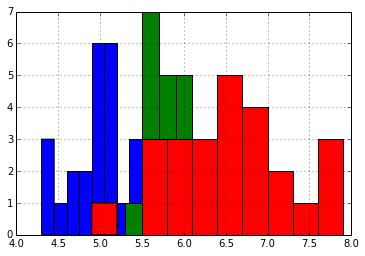

In [416]:
iris_training.groupby('Species')['Sepal.Length'].hist()
plt.show()

In [417]:
model = lda(iris_training.Species, iris_training['Sepal.Length'])

In [418]:
predictions = np.array([model.predict(x) for x in iris_test['Sepal.Length']])
truth = iris_test['Species'].values

In [419]:
results = pd.DataFrame(np.array([predictions, truth]).T, 
                       columns=['Prediction', 'Truth'])
vcounts = results.groupby('Prediction').Truth.value_counts()
vcounts_dense = np.zeros((3,3))
for i in xrange(model.K):
    k_i = model.K_labels[i]
    for j in xrange(model.K):
        k_j = model.K_labels[j]
        try:
            vcounts_dense[i,j] = vcounts[k_i][k_j]
        except KeyError:
            pass
comparison = pd.DataFrame(vcounts_dense, columns=model.K_labels)
comparison['Truth'] = model.K_labels
comparison        

,setosa,versicolor,virginica,Truth
0,21,4,0,setosa
1,4,13,5,versicolor
2,0,8,20,virginica


In [420]:
x = stats.norm.rvs(loc=4, scale=1.3, size=200)

In [606]:
def qda(K_x, X):
    K = set(K_x)
    X_grouped = {k:[] for k in list(K)}
    for k, x in zip(K_x, X):
        X_grouped[k].append(x)
    
    # Maximize f to find mu and sigma
    params_k = {}
    for k, x in X_grouped.iteritems():
        guess = (np.mean(x), np.std(x))
        
        # Variance must be greater than 0.
        constraints = {'type': 'eq', 'fun': lambda params: params[1] > 0}
        f = lambda params: np.sum(((-1.*(x - params[0])**2)/(2.*params[1]**2)) - np.log(params[1]*np.sqrt(2.*np.pi)))
        params_k[k] = optimize.minimize(lambda params: -1.*f(params), guess, constraints=constraints).x

    K_ordered = np.array(params_k.keys())[np.argsort(np.array(zip(*params_k.values())[0]))]
    X_bound = []
    for i in xrange(1, len(K_ordered)):
        k_0, k_1 = K_ordered[i-1], K_ordered[i]
        mu_0, sigma2_0 = params_k[k_0]
        mu_1, sigma2_1 = params_k[k_1]
        delta_0 = lambda x: ((-1.*(x - mu_0)**2)/(2.*sigma2_0**2)) - np.log(sigma2_0*np.sqrt(2.*np.pi))
        delta_1 = lambda x: ((-1.*(x - mu_1)**2)/(2.*sigma2_1**2)) - np.log(sigma2_1*np.sqrt(2.*np.pi))
        bound = lambda x: np.abs(delta_0(x) - delta_1(x))
        o = optimize.minimize(bound, mu_0 + (mu_1-mu_0))
        X_bound.append(o.x)

    mu, sigma = zip(*params_k.values())
    return LDAModel_1D(mu, sigma, params_k.keys())

In [607]:
qmodel = qda(iris_training.Species, iris_training['Sepal.Length'])

$P(Y=k|X=x) \propto \frac{-(x-\mu_k)^2}{2\sigma_k^2} - log(\sigma_k\sqrt{2\pi})$

$-\sum_{x \in X} \frac{-(x-\mu_k)^2}{2\sigma_k^2} - log(\sigma_k\sqrt{2\pi})$

$\bigg|\bigg(\frac{-(x-\mu_k)^2}{2\sigma_k^2} - log(\sigma_k\sqrt{2\pi})\bigg) - \bigg(\frac{-(x-\mu_{k'})^2}
{2\sigma_{k'}^2} - log(\sigma_{k'}\sqrt{2\pi})\bigg)\bigg|$

In [608]:
qpredictions = np.array([qmodel.predict(x) for x in iris_test['Sepal.Length']])

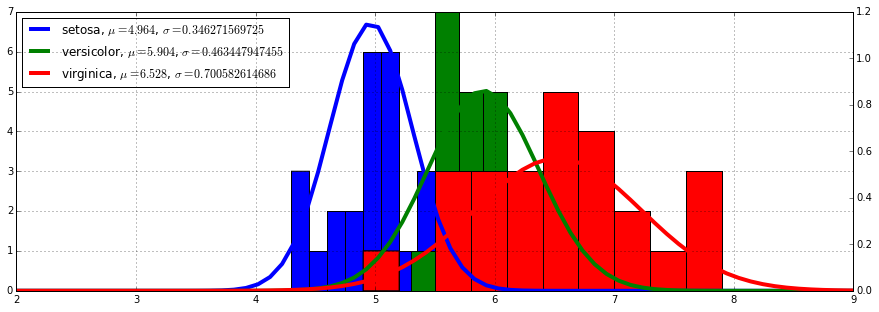

In [609]:
plt.figure(figsize=(15, 5))
X_ = np.linspace(0, 20, 200)
iris_training.groupby('Species')['Sepal.Length'].hist()
# iris_test.groupby('Species')['Sepal.Length'].hist()

ax = plt.gca()
ax2 = ax.twinx()
for k in qmodel.K_labels:
    i = qmodel.K_labels.index(k)
    ax2.plot(X_, stats.norm.pdf(X_, loc=qmodel.mu[i], scale=qmodel.sigma[i]), 
             label='{0}, $\mu={1}$, $\sigma={2}$'.format(k, qmodel.mu[i], qmodel.sigma[i]), lw=4)


plt.legend(loc=2)
plt.xlim(2, 9)
plt.show()

In [610]:
results = pd.DataFrame(np.array([qpredictions, truth]).T, 
                       columns=['Prediction', 'Truth'])
vcounts = results.groupby('Prediction').Truth.value_counts()
vcounts_dense = np.zeros((3,3))
for i in xrange(qmodel.K):
    k_i = qmodel.K_labels[i]
    for j in xrange(qmodel.K):
        k_j = qmodel.K_labels[j]
        try:
            vcounts_dense[i,j] = vcounts[k_i][k_j]
        except KeyError:
            pass
comparison = pd.DataFrame(vcounts_dense, columns=qmodel.K_labels)
comparison['Truth'] = qmodel.K_labels
comparison       

ValueError: Shape of passed values is (1, 2), indices imply (2, 2)

In [ ]:
c = np.array(zip(qpredictions, truth)).T
float((c[0] == c[1]).sum())/c.shape[1]

In [ ]:
Hemocrit = pd.read_csv('data/Hemocrit.csv')

In [ ]:
model = lda(Hemocrit.status, Hemocrit.hemocrit)

The default approach was to predict 'Cheat' when $P(Cheater\big|X) > 0.5$. 

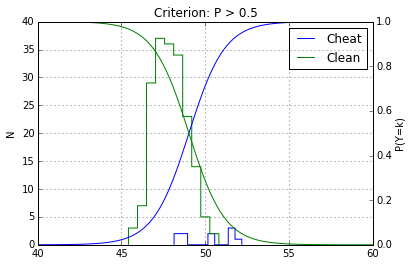

In [611]:
# Histogram of hemocrit values for cheaters and non-cheaters.
Hemocrit[Hemocrit.status == 'Cheat'].hemocrit.hist(histtype='step')
Hemocrit[Hemocrit.status == 'Clean'].hemocrit.hist(histtype='step')
plt.ylim(0, 40)
plt.ylabel('N')

# Probability of being a cheater (or not) as a function of hemocrit.
ax = plt.gca()
ax2 = ax.twinx()

R = np.linspace(0, 100, 500)
post = np.array([model.posterior(r) for r in R])
ax2.plot(R, post[:, 0], label=model.K_labels[0])
ax2.plot(R, post[:, 1], label=model.K_labels[1])
plt.ylabel('P(Y=k)')

plt.xlabel('Hemocrit')
plt.legend()
plt.xlim(40, 60)
plt.title('Criterion: P > 0.5')
plt.show()

Confusion matrix:

In [612]:
predictions = [model.predict(h) for h in Hemocrit.hemocrit]
truth = Hemocrit.status.values
confusion = pd.DataFrame(np.array([predictions, truth]).T, columns=('Prediction', 'Truth'))

confusion.groupby('Prediction').Truth.value_counts()

Prediction       
Cheat       Clean     25
            Cheat      6
Clean       Clean    165
            Cheat      4
dtype: int64

Trying the same thing, but with QDA:

In [613]:
qmodel = qda(Hemocrit.status, Hemocrit.hemocrit)
qpredictions = np.array([qmodel.predict(h) for h in Hemocrit.hemocrit])
truth = Hemocrit.status.values
qconfusion = pd.DataFrame(np.array([qpredictions, truth]).T, columns=('Prediction', 'Truth'))

## Receiver Operator Characteristic (ROC) curve 

Provides a visual summary of the confusion matrix over a range of criteria. Given a confusion matrix, $N=TN+FP$, $P=TP+FN$.

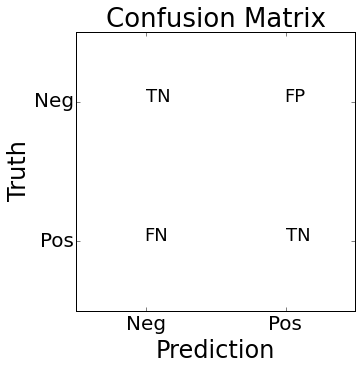

In [614]:
plt.figure(figsize=(5, 5))
plt.text(0.25, 0.75, 'TN', size=18)
plt.text(0.75, 0.75, 'FP', size=18)
plt.text(0.25, 0.25, 'FN', size=18)
plt.text(0.75, 0.25, 'TN', size=18)

plt.xticks([0.25, 0.75], ['Neg', 'Pos'], size=20)
plt.yticks([0.25, 0.75], ['Pos', 'Neg'], size=20)
plt.ylabel('Truth', size=24)
plt.xlabel('Prediction', size=24)
plt.title('Confusion Matrix', size=26)
plt.show()

The true positive rate, or **Power** (or Sensitivity) is $\frac{TP}{P}$ and the **Type 1 error** is $\frac{FP}{N}$. The ROC curve shows Power vs. Type 1 error. Ideally, we can achieve a high true positive rate at a very low false positive rate:

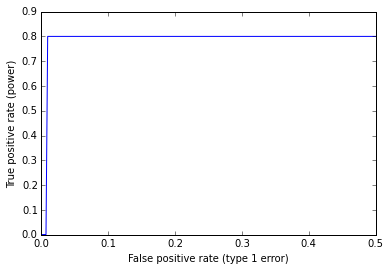

In [615]:
plt.figure()
X = np.linspace(0., 0.5, 200)
f = lambda x: 0.001 if x < 0.01 else 0.8
plt.plot(X, map(f, X))
plt.ylabel('True positive rate (power)')
plt.xlabel('False positive rate (type 1 error)')
plt.show()

With the hemocrit example:

In [616]:
ROC = []
C = []
for p in np.arange(0.5, 1.0, 0.005):
    criterion = lambda posterior: 0 if posterior[0] > p else 1
    predictions = [model.predict(h, criterion) for h in Hemocrit.hemocrit]
    truth = Hemocrit.status.values
    confusion = pd.DataFrame(np.array([predictions, truth]).T, columns=('Prediction', 'Truth'))
    
    FP = confusion[confusion['Prediction'] == 'Cheat'][confusion['Truth'] == 'Clean'].shape[0]
    N = confusion[confusion['Truth'] == 'Clean'].shape[0]
    FP_rate = float(FP)/N

    TP = confusion[confusion['Prediction'] == 'Cheat'][confusion['Truth'] == 'Cheat'].shape[0]
    P = confusion[confusion['Truth'] == 'Cheat'].shape[0]
    TP_rate = float(TP)/P
    ROC.append((FP_rate, TP_rate))
    C.append(p)

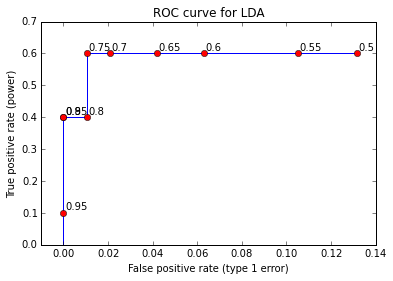

In [617]:
plt.title('ROC curve for LDA')
FP_rate, TP_rate = zip(*ROC)
plt.plot(FP_rate, TP_rate)
for i in xrange(0, len(FP_rate), 10):
    plt.plot(FP_rate[i], TP_rate[i], 'ro')
    plt.text(FP_rate[i]+0.001, TP_rate[i]+0.01, C[i])
plt.xlim(-0.01, 0.14)
plt.ylim(0, .7)
plt.ylabel('True positive rate (power)')
plt.xlabel('False positive rate (type 1 error)')
plt.show()

In [618]:
QROC = []
C = []
for p in np.arange(0.5, 1.0, 0.005):
    criterion = lambda posterior: 0 if posterior[0] > p else 1
    predictions = [qmodel.predict(h, criterion) for h in Hemocrit.hemocrit]
    truth = Hemocrit.status.values
    confusion = pd.DataFrame(np.array([predictions, truth]).T, columns=('Prediction', 'Truth'))
    
    FP = confusion[confusion['Prediction'] == 'Cheat'][confusion['Truth'] == 'Clean'].shape[0]
    N = confusion[confusion['Truth'] == 'Clean'].shape[0]
    FP_rate = float(FP)/N

    TP = confusion[confusion['Prediction'] == 'Cheat'][confusion['Truth'] == 'Cheat'].shape[0]
    P = confusion[confusion['Truth'] == 'Cheat'].shape[0]
    TP_rate = float(TP)/P
    QROC.append((FP_rate, TP_rate))
    C.append(p)

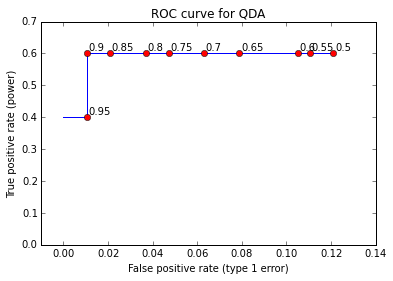

In [619]:
plt.title('ROC curve for QDA')
FP_rate, TP_rate = zip(*QROC)
plt.plot(FP_rate, TP_rate)
for i in xrange(0, len(FP_rate), 10):
    plt.plot(FP_rate[i], TP_rate[i], 'ro')
    plt.text(FP_rate[i]+0.001, TP_rate[i]+0.01, C[i])
plt.xlim(-0.01, 0.14)
plt.ylim(0, .7)
plt.ylabel('True positive rate (power)')
plt.xlabel('False positive rate (type 1 error)')
plt.show()